采集串口数据并画图

花费时间：2.01328 s 共收到：64 帧数据, 应收到：2000 帧数据!


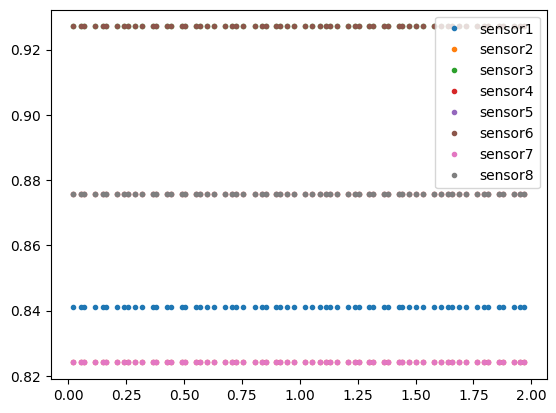

In [67]:
import serial
import struct
import time
import timeit
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import os
import matplotlib.animation as animation


#接收数据时间
receive_time = 2
#接收数据波特率
ser_baudrate = 1000000
#接收数据串口
ser_port = 'COM3'

#采样率
sampling_rate = 1000

# 定义串口数据开头和结尾标识符
START_BYTE = b'\xCD'
END_BYTE = b'\xAB'

# 定义每帧每个数据bit = 24 bit
data_bit = 24

# 定义每帧有多少个数据sensor_number = 8
sensor_number = 8

# 定adc通道名
data_str = "sensor"

#ADC比例系数
ADC_coefficient = 100000000*9.8112

############################## 这里可能存在问题，还是直接求START_BYTE和END_BYTE的位宽吧 ##################################
data_frame_flag_bit = (sys.getsizeof(START_BYTE) + sys.getsizeof(END_BYTE)-64)*4

# 创建串口对象并设置参数
try:
    ser = serial.Serial(
       port = ser_port, 	# 指定要操作的端口号（如果在此处显示了说明，这个参数也是必需
       baudrate = ser_baudrate,  # 指定要操作的速率（单位是位），必须是1M	
       bytesize = 8,     # 指定每个数据包的大小，可选值有 8 N 1
       parity = serial.PARITY_NONE,  # 指定校验方式,必须是serial.PARITY_NONE
       stopbits = 1,     # 指定每个数据包的停止位数，可选值有 1 2 1.5 2
       timeout = 1       # 指定连接时的等待时间，单位是秒，如果没有发送数据，则等待    
    )
except Exception:
    ser = serial.Serial(
       port = ser_port, 	# 指定要操作的端口号（如果在此处显示了说明，这个参数也是必需
       baudrate = ser_baudrate,  # 指定要操作的速率（单位是位），必须是1M	
       bytesize = 8,     # 指定每个数据包的大小，可选值有 8 N 1
       parity = serial.PARITY_NONE,  # 指定校验方式,必须是serial.PARITY_NONE
       stopbits = 1,     # 指定每个数据包的停止位数，可选值有 1 2 1.5 2
       timeout = 1       # 指定连接时的等待时间，单位是秒，如果没有发送数据，则等待    
    )
    
    ser.close()
# 保存十进制和十六进制数据的列表
sensorlist = [data_str + str(i) for i in range(1, sensor_number+1)]
data_list = [['time'] + sensorlist]

data_hex_list = [['time',str(START_BYTE)[4:],sensorlist,str(END_BYTE)[4:]]]

# 开始时间
start_time = time.time()

# 定义每帧数据长度（以bit为单位）
FRAME_LENGTH = data_bit*sensor_number + data_frame_flag_bit

#接收数据帧数统计
j = 0

while True:
    try:    # 可能引发异常的代码块
        
        # 读取一个字节
        byte = ser.read(1)
        
        # 检查是否为开头标识符
        if byte == START_BYTE:
            
            # 读取数据帧
            data_frame = ser.read(FRAME_LENGTH // 8 - 2)

            # 读取结尾标识符
            end_byte = ser.read(1)
            
            # 检查结尾标识符
            if end_byte == END_BYTE:  
                # 解析数据帧
                new_time = time.time()                
                data_points = [new_time-start_time]
                data_list.append((data_points)) # type: ignore
                raw_data = str(new_time-start_time) + " " + byte.hex().upper()+' '
                for i in range(0, FRAME_LENGTH-16, 24):
                    point_data = data_frame[i//8 : (i+24)//8]
                    # print(i)
                    # 解析为有符号整数
                    signed_value = struct.unpack('>i', point_data + b'\x00')[0]

                    # 转换为浮点数
                    float_value = float(signed_value)/ADC_coefficient
                    
                    # 插入时间
                    # 保存解析后的浮点数
                    data_points.append(float_value)

                    # 保存原始数据
                    raw_data += ' '.join([f'{b:02X}' for b in point_data]) + " "

                    # 保存每帧数据及其原始数据
                data_hex_list.append((raw_data + end_byte.hex().upper()))    # type: ignore
                
                # 打印每帧数据及其原始数据
                # print(f"Data Frame: {data_points}")
                # print(f"Raw Data: {raw_data}")
                j += 1
############################以上不断完成数据采集过程####################################

    except Exception as e:
        print("出错了：", str(e))

    finally:    # 无论是否引发异常都会执行的代码块 
    # 持续接收并处理数据，直到达到指定时间
        current_time = time.time()
        if current_time - start_time >= receive_time:
            # 关闭串口
            ser.close()
            # 打印信息
            print("花费时间：%0.5f s"%(time.time()-start_time),"共收到：%d 帧数据,"%(j),"应收到：%d 帧数据!"%(sampling_rate*receive_time))
            
            # 数据保存和转换
            if j < 2:
                sensor_data_list = ['' + str(' ') for i in range(1, sensor_number+2)]
                data_list.append(sensor_data_list)
                data_hex_list.append([])
            # 将列表转换为DataFrame对象
            df = pd.DataFrame(data_list[1:], columns=data_list[0])

            if len(df["time"]) > 1:
                # 收到数据作图
                plt.plot(df["time"],df[sensorlist],'.')
                plt.legend(sensorlist)
                # plt.ylim([0,2])
                plt.show()
            break
            # if j > 1:
            #     # 收到数据作图
            
            #     plt.plot(df["time"][:-1],df[sensorlist][:-1],'.')
            #     plt.legend(sensorlist)
            #     # plt.ylim([0,2])
            #     plt.show()
            # break

保存数据到时间文件夹下，格式：1_备注.csv

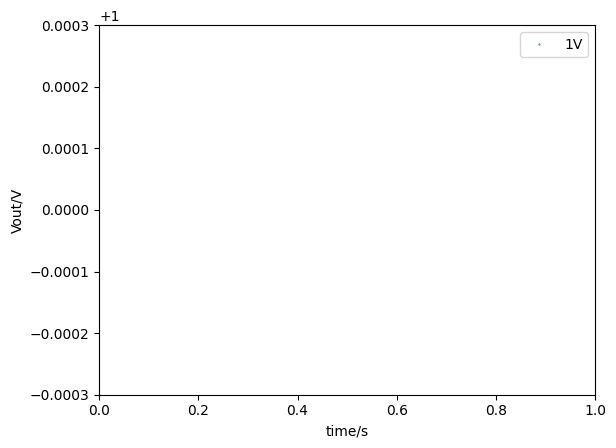

In [26]:
plt.plot(df["time"],-df[sensorlist[3]],'.',markersize=1)
plt.legend(["1V"])
plt.xlabel("time/s")
plt.ylabel("Vout/V")
plt.xlim([0,1])
plt.ylim([0.9997,1.0003])
plt.show()

In [27]:

confirm_str = input("enter:'1_备注.csv': make sure to save data in path")
if confirm_str[0] == "1":
    save_data_path = '../../data/nrf_samples_data/'
    # save_data_path = 'F:\\My_work_file\\OneDrive - stu.xjtu.edu.cn\\My_Documents\\3.代码仓库\\python_work\\get_data\\data_list\\'
    # 获取当前日期时间
    current_datetime = datetime.now()
    # 指定的日期时间格式
    datetime_format = '%Y%m%d%H%M%S'
    # 格式化日期时间
    formatted_datetime = current_datetime.strftime(datetime_format)

    #文件夹名和路径
    folder_name = save_data_path + formatted_datetime[0:8]
    # 文件名
    if (len(confirm_str) > 4) & (confirm_str[-4:] == '.csv'):
        csv_file = folder_name + '\\' + formatted_datetime[8:] + confirm_str[1:]
    elif confirm_str == '1':
        csv_file = folder_name + '\\' + formatted_datetime[8:] + '.csv'   
    else:
        csv_file = folder_name + '\\' + formatted_datetime[8:] + confirm_str[1:] + '.txt'   

    hex_txt_file = folder_name + '\\' + formatted_datetime[8:] + confirm_str[1:] + '.txt'   

    print(folder_name)
    # 检查文件夹是否已存在
    if not os.path.exists(folder_name):
        # 建立文件夹日期文件夹并保存该数据
        os.mkdir(folder_name)
        if csv_file[-4:] == '.csv':
            df.to_csv(csv_file, index=False)
        else:
            df.to_csv(csv_file, index=False, sep='\t')
        with open(hex_txt_file, 'w') as f:
            for item in data_hex_list:
                f.write("%s\n" % item)
    else:
        print("文件夹已存在:", folder_name)
        # 分类别存储
        if csv_file[-4:] == '.csv':
            df.to_csv(csv_file, index=False)   
        else:
            df.to_csv(csv_file, index=False, sep='\t')

        with open(hex_txt_file, 'w') as f:
                for item in data_hex_list:
                    f.write("%s\n" % item)


../../data/nrf_samples_data/20231129
文件夹已存在: ../../data/nrf_samples_data/20231129
